In [2]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import NMF

import utils.sulfur.constant as const
from utils.CaImageCSV import CaImageCSV
from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
def split_engram_matrix(animal_name, context_name):
    csv = ContextDataCSV(animal_name, context_name)
    matrix = csv.data_frame
    matrix = MatrixOptimizer(matrix).divide_sd()
    
    engram_df = matrix.loc[:, csv.engram_cells()]
    non_engram_df = matrix.loc[:, csv.non_engram_cells()]
    
    return engram_df, non_engram_df

def droped_unique_cells(cells1, cells2):
    droped_cells = np.array([])
    droped_cells = np.append(droped_cells, cells1)
    droped_cells = np.append(droped_cells, cells2)
    droped_cells = np.unique(droped_cells)
    return droped_cells

def all_nan_cells(matrix):
    nan_cells = np.array([])
    for cell_name, items in matrix.iteritems():
        if items.isnull().all():
            nan_cells = np.append(nan_cells, cell_name)
            
    return nan_cells

def split_matrix(matrix, context_name):
    matrix_1 = matrix.iloc[0:400, :]
    matrix_2 = matrix.iloc[900:1300, :]
    matrix_3 = matrix.iloc[1800:2200, :]
    
    return matrix_1, matrix_2, matrix_3

def AICc(distance, K, N):
    return 2 * distance + 2 * K * (N / (N - K - 1)) # 対数尤度=-Dis(x,y) より 

def setted_NMF(df, components_size):
    model = NMF(n_components=components_size, init='random', random_state=0, beta_loss='kullback-leibler', solver='mu', max_iter=2000)
    model.fit(df)
    W = model.transform(df)
    H = model.components_
    
    return W, H, model

def calc_matching_score(base_pattern_vectors, comp_pattern_vectors):
    threshold = 0.6
    similarities = cosine_similarity(base_pattern_vectors, comp_pattern_vectors)
    matching_score = 0
    for similarity in similarities:
        if len(similarity[similarity > threshold]) > 0:
            matching_score += 1
        
    return matching_score / len(base_pattern_vectors)
    
def build_pattern_vectors(dfs):
    patterns = {}
    for context_name, df in dfs.items():
        min_aic_value = float('inf')
        min_H = None
        upper_count = 0
        
        for n in range(1, len(df.columns) + 1):
            _, H, model = setted_NMF(df, n)
            err = model.reconstruction_err_
            aic_value = AICc(err, n, len(columns) * len(df))
            if min_aic_value > aic_value:
                upper_count = 0
                min_aic_value = aic_value
                min_H = H
                
            if min_aic_value < aic_value:
                upper_count += 1
                
            if upper_count > 20:
                break
                
        patterns[context_name] = min_H
        
    return patterns

In [3]:
index = const.ANIMAL_NAMES
columns = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
engram_matching_score = pd.DataFrame(index=index, columns=columns)
non_engram_matching_score = pd.DataFrame(index=index, columns=columns)

for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    A1postES_engram, A1postES_non_engram = split_engram_matrix(animal_name, 'A1postES')
    A4postES_engram, A4postES_non_engram = split_engram_matrix(animal_name, 'A4postES')

    A1postES_nan_engram_cells = all_nan_cells(A1postES_engram)
    A1postES_nan_non_engram_cells = all_nan_cells(A1postES_non_engram)
    A4postES_nan_engram_cells = all_nan_cells(A4postES_engram)
    A4postES_nan_non_engram_cells = all_nan_cells(A4postES_non_engram)
    
    droped_engram_cells = droped_unique_cells(A1postES_nan_engram_cells, A4postES_nan_engram_cells)
    droped_non_engram_cells = droped_unique_cells(A1postES_nan_non_engram_cells, A4postES_nan_non_engram_cells)
    
    A1postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A1postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)

    A4postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A4postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)
    
    engram_A1postES_1, engram_A1postES_2, engram_A1postES_3 = split_matrix(A1postES_engram, 'A1postES')
    engram_A4postES_1, engram_A4postES_2, engram_A4postES_3 = split_matrix(A4postES_engram, 'A4postES')

    non_engram_A1postES_1, non_engram_A1postES_2, non_engram_A1postES_3 = split_matrix(A1postES_non_engram, 'A1postES')
    non_engram_A4postES_1, non_engram_A4postES_2, non_engram_A4postES_3 = split_matrix(A4postES_non_engram, 'A4postES')
    
    engram_df = {}
    engram_df['A1_1'] = engram_A1postES_1
    engram_df['A1_2'] = engram_A1postES_2
    engram_df['A1_3'] = engram_A1postES_3
    engram_df['A4_1'] = engram_A4postES_1
    engram_df['A4_2'] = engram_A4postES_2
    engram_df['A4_3'] = engram_A4postES_3
    engram_patterns = build_pattern_vectors(engram_df)

    engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A1_1'])
    engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A1_2'])
    engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A1_3'])
    engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A4_1'])
    engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A4_2'])
    engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A4_3'])

    non_engram_df = {}
    non_engram_df['A1_1'] = non_engram_A1postES_1
    non_engram_df['A1_2'] = non_engram_A1postES_2
    non_engram_df['A1_3'] = non_engram_A1postES_3
    non_engram_df['A4_1'] = non_engram_A4postES_1
    non_engram_df['A4_2'] = non_engram_A4postES_2
    non_engram_df['A4_3'] = non_engram_A4postES_3
    non_engram_patterns = build_pattern_vectors(non_engram_df)
    
    non_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A1_1'])
    non_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A1_2'])
    non_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A1_3'])
    non_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A4_1'])
    non_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A4_2'])
    non_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A4_3'])
    
print(engram_matching_score)
print(non_engram_matching_score)

animal_name: ID181106CreA
animal_name: ID181106CreB
animal_name: ID181106CreC
animal_name: ID181106CreG


/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


animal_name: ID181106CreH
animal_name: ID181106CreI
animal_name: ID181106CreK
animal_name: ID181106CreL
animal_name: ID181106CreN
animal_name: ID181106CreQ
             A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  1.0  0.769231  0.846154  0.884615  0.884615  0.884615
ID181106CreB  1.0  0.928571       1.0  0.857143  0.857143  0.928571
ID181106CreC  1.0       1.0  0.833333  0.833333  0.777778  0.944444
ID181106CreG  1.0  0.947368  0.947368  0.947368  0.894737  0.842105
ID181106CreH  1.0  0.764706  0.676471  0.764706  0.588235  0.647059
ID181106CreI  1.0   0.73913  0.521739  0.608696  0.391304  0.521739
ID181106CreK  1.0  0.761905  0.857143  0.857143       1.0  0.857143
ID181106CreL  1.0  0.866667       0.8  0.733333       0.8  0.666667
ID181106CreN  1.0       1.0     0.875    0.9375      0.75    0.9375
ID181106CreQ  1.0  0.941176  0.882353  0.823529  0.882353  0.764706


NameError: name 'non_engram_matchig_score' is not defined

In [10]:
engram_matching_score

,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
ID181106CreA,1.0,0.769231,0.846154,0.884615,0.884615,0.884615
ID181106CreB,1.0,0.928571,1.0,0.857143,0.857143,0.928571
ID181106CreC,1.0,1.0,0.833333,0.833333,0.777778,0.944444
ID181106CreG,1.0,0.947368,0.947368,0.947368,0.894737,0.842105
ID181106CreH,1.0,0.764706,0.676471,0.764706,0.588235,0.647059
ID181106CreI,1.0,0.73913,0.521739,0.608696,0.391304,0.521739
ID181106CreK,1.0,0.761905,0.857143,0.857143,1.0,0.857143
ID181106CreL,1.0,0.866667,0.8,0.733333,0.8,0.666667
ID181106CreN,1.0,1.0,0.875,0.9375,0.75,0.9375
ID181106CreQ,1.0,0.941176,0.882353,0.823529,0.882353,0.764706


In [11]:
non_engram_matching_score

,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
ID181106CreA,1.0,0.22449,0.183673,0.040816,0.0,0.020408
ID181106CreB,1.0,0.368421,0.421053,0.105263,0.026316,0.026316
ID181106CreC,1.0,0.457143,0.514286,0.257143,0.171429,0.257143
ID181106CreG,1.0,0.27907,0.418605,0.0,0.0,0.0
ID181106CreH,1.0,0.514286,0.542857,0.028571,0.142857,0.057143
ID181106CreI,1.0,0.466667,0.266667,0.166667,0.133333,0.166667
ID181106CreK,1.0,0.195122,0.268293,0.0,0.04878,0.02439
ID181106CreL,1.0,0.414634,0.390244,0.0,0.04878,0.02439
ID181106CreN,1.0,0.5,0.5,0.0,0.0,0.0
ID181106CreQ,1.0,0.32,0.24,0.0,0.0,0.02


In [4]:
engram_matching_score.mean()

A1_1    1.000000
A1_2    0.871875
A1_3    0.823956
A4_1    0.824737
A4_2    0.782617
A4_3    0.799455
dtype: float64

In [5]:
non_engram_matching_score.mean()

A1_1    1.000000
A1_2    0.373983
A1_3    0.374568
A4_1    0.059846
A4_2    0.057150
A4_3    0.059646
dtype: float64

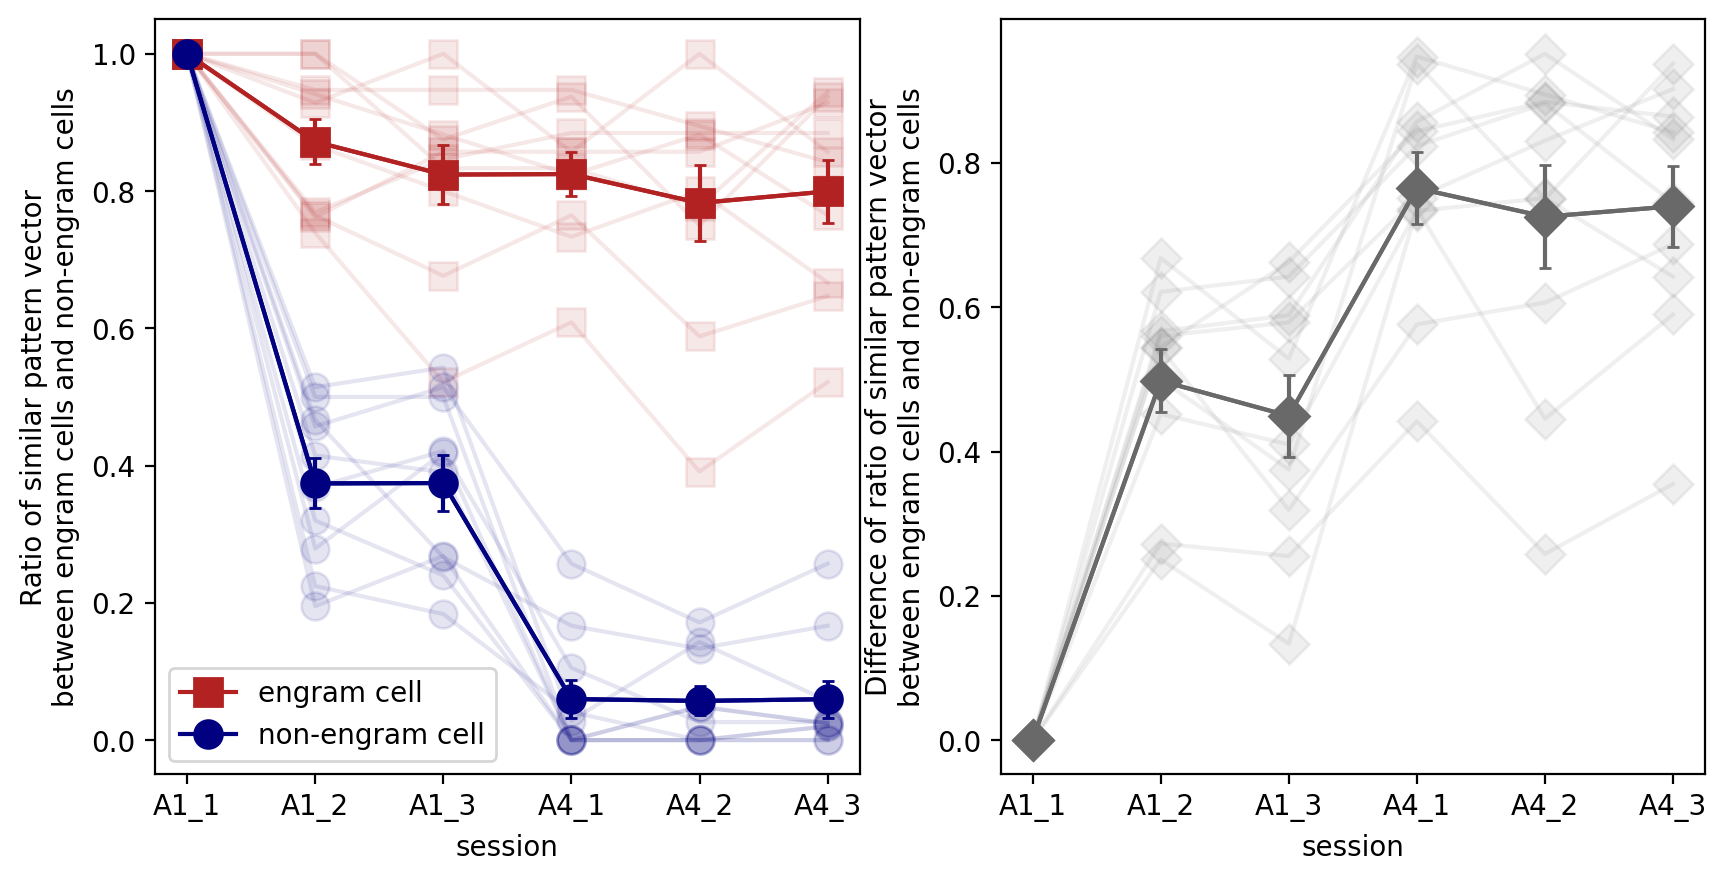

In [23]:
x = engram_matching_score.columns
engram_y, engram_err = engram_matching_score.mean(), engram_matching_score.sem()
non_engram_y, non_engram_err = non_engram_matching_score.mean(), non_engram_matching_score.sem()

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), dpi=200)

axes[0].errorbar(x, engram_y, yerr=engram_err, capsize=2, c='firebrick')
axes[0].plot(x, engram_y, marker='s', markersize=10, label='engram cell', c='firebrick', zorder=12)
axes[0].errorbar(x, non_engram_y, yerr=non_engram_err, capsize=2, c='navy')
axes[0].plot(x, non_engram_y, marker='o', markersize=10, label='non-engram cell', c='navy', zorder=12)

for index, rows in engram_matching_score.iterrows():
    axes[0].plot(x, rows, marker='s', markersize=10, c='firebrick', alpha=0.1)
    
for index, rows in non_engram_matching_score.iterrows():
    axes[0].plot(x, rows, marker='o', markersize=10, c='navy', alpha=0.1)

axes[0].set_xlabel('session')
axes[0].set_ylabel('Ratio of similar pattern vector\nbetween engram cells and non-engram cells')
axes[0].legend()

diffs = engram_matching_score - non_engram_matching_score
diff_mean, diff_err = diffs.mean(), diffs.sem()

axes[1].errorbar(x, diff_mean, yerr=diff_err, capsize=2, c='dimgray')
axes[1].plot(x, diff_mean, marker='D', markersize=10, c='dimgray', zorder=12)

for index, rows in diffs.iterrows():
    axes[1].plot(x, rows, marker='D', markersize=10, c='dimgray', alpha=0.1)
    
axes[1].set_xlabel('session')
axes[1].set_ylabel('Difference of ratio of similar pattern vector\nbetween engram cells and non-engram cells')

fig.show()

In [31]:
index = const.ANIMAL_NAMES
columns = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
shuffle_engram_matching_score = pd.DataFrame(0.0, index=index, columns=columns)

shuffled_count = 10

for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    a1_csv = ContextDataCSV(animal_name, 'A1postES')
    a1_matrix = a1_csv.data_frame
    a1_matrix = MatrixOptimizer(a1_matrix).divide_sd()
    
    a4_csv = ContextDataCSV(animal_name, 'A4postES')
    a4_matrix = a4_csv.data_frame
    a4_matrix = MatrixOptimizer(a4_matrix).divide_sd()

    a1_nan_cells = all_nan_cells(a1_matrix)
    a4_nan_cells = all_nan_cells(a4_matrix)
    
    droped_cells = droped_unique_cells(a1_nan_cells, a4_nan_cells)
    a1_matrix.drop(columns=droped_cells, inplace=True)
    a4_matrix.drop(columns=droped_cells, inplace=True)
    
    for i in range(shuffled_count):
        random_cells = np.random.randint(0, len(a1_matrix.columns), size=len(a1_csv.engram_cells()))
        a1_shuffle_df = a1_matrix.iloc[:, random_cells].copy(deep=True)
        a4_shuffle_df = a4_matrix.iloc[:, random_cells].copy(deep=True)
        
        shuffled_a1_1, shuffled_a1_2, shuffled_a1_3 = split_matrix(a1_shuffle_df, 'A1postES')
        shuffled_a4_1, shuffled_a4_2, shuffled_a4_3 = split_matrix(a4_shuffle_df, 'A4postES')
        
        shuffled_df = {}
        shuffled_df['A1_1'] = shuffled_a1_1
        shuffled_df['A1_2'] = shuffled_a1_2
        shuffled_df['A1_3'] = shuffled_a1_3
        shuffled_df['A4_1'] = shuffled_a4_1
        shuffled_df['A4_2'] = shuffled_a4_2
        shuffled_df['A4_3'] = shuffled_a4_3
        shuffled_patterns = build_pattern_vectors(shuffled_df)

        shuffle_engram_matching_score.loc[animal_name, 'A1_1'] += calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A1_1'])
        shuffle_engram_matching_score.loc[animal_name, 'A1_2'] += calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A1_2'])
        shuffle_engram_matching_score.loc[animal_name, 'A1_3'] += calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A1_3'])
        shuffle_engram_matching_score.loc[animal_name, 'A4_1'] += calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A4_1'])
        shuffle_engram_matching_score.loc[animal_name, 'A4_2'] += calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A4_2'])
        shuffle_engram_matching_score.loc[animal_name, 'A4_3'] += calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A4_3'])
        print(shuffle_engram_matching_score)
        
shuffle_engram_matching_score /= shuffled_count
shuffle_engram_matching_score

animal_name: ID181106CreA
              A1_1      A1_2      A1_3      A4_1     A4_2      A4_3
ID181106CreA   1.0  0.484848  0.454545  0.333333  0.30303  0.272727
ID181106CreB   0.0  0.000000  0.000000  0.000000  0.00000  0.000000
ID181106CreC   0.0  0.000000  0.000000  0.000000  0.00000  0.000000
ID181106CreG   0.0  0.000000  0.000000  0.000000  0.00000  0.000000
ID181106CreH   0.0  0.000000  0.000000  0.000000  0.00000  0.000000
ID181106CreI   0.0  0.000000  0.000000  0.000000  0.00000  0.000000
ID181106CreK   0.0  0.000000  0.000000  0.000000  0.00000  0.000000
ID181106CreL   0.0  0.000000  0.000000  0.000000  0.00000  0.000000
ID181106CreN   0.0  0.000000  0.000000  0.000000  0.00000  0.000000
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.00000  0.000000
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA   2.0  0.873737  0.871212  0.777778  0.608586  0.744949
ID181106CreB   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreC   0.0 

              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB   2.0  1.291667  1.535038  1.447917  1.476326  1.508523
ID181106CreC   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreG   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreH   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreI   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreK   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreL   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreN   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
              A1_1      A1_2      A1_3     A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.92058  3.913385  3.935104
ID181106CreB   3.0  2.208333  2.173927  2.28125  2.170770  2.036301
ID181106CreC   0.0  0.000000  0.00000

/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB   6.0  4.532967  4.334764  4.806113  4.445368  3.851881
ID181106CreC   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreG   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreH   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreI   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreK   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreL   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreN   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB   7.0  5.291587  5.127868  5.702665  5.238472  4.507053
ID181106CreC   0.0  0.000000  0.00

              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC   7.0  4.544662  4.187802  4.638161  3.454013  4.243693
ID181106CreG   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreH   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreI   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreK   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreL   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreN   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC   8.0  4.982162  4.75

              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.509918  6.488322  4.589430  5.534558
ID181106CreG   8.0  2.666696  3.648607  2.728915  2.961102  2.879724
ID181106CreH   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreI   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreK   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreL   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreN   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.50

              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.509918  6.488322  4.589430  5.534558
ID181106CreG  10.0  3.450860  4.220765  3.404522  3.789966  3.592367
ID181106CreH   9.0  3.063168  1.596865  2.543295  1.666439  1.259576
ID181106CreI   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreK   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreL   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreN   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.50

              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.509918  6.488322  4.589430  5.534558
ID181106CreG  10.0  3.450860  4.220765  3.404522  3.789966  3.592367
ID181106CreH  10.0  3.375668  1.721865  2.762045  1.728939  1.415826
ID181106CreI  10.0  2.733565  2.066219  1.582872  1.747092  1.378988
ID181106CreK   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreL   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreN   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
animal_name: ID181106CreK
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106

              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.509918  6.488322  4.589430  5.534558
ID181106CreG  10.0  3.450860  4.220765  3.404522  3.789966  3.592367
ID181106CreH  10.0  3.375668  1.721865  2.762045  1.728939  1.415826
ID181106CreI  10.0  2.733565  2.066219  1.582872  1.747092  1.378988
ID181106CreK  10.0  7.462187  4.942338  7.156430  7.528553  5.805529
ID181106CreL   1.0  0.724138  0.620690  0.862069  0.482759  0.482759
ID181106CreN   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.50

              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.509918  6.488322  4.589430  5.534558
ID181106CreG  10.0  3.450860  4.220765  3.404522  3.789966  3.592367
ID181106CreH  10.0  3.375668  1.721865  2.762045  1.728939  1.415826
ID181106CreI  10.0  2.733565  2.066219  1.582872  1.747092  1.378988
ID181106CreK  10.0  7.462187  4.942338  7.156430  7.528553  5.805529
ID181106CreL  10.0  6.749081  5.744761  7.264286  5.903012  5.561897
ID181106CreN   2.0  1.495652  1.488696  1.412174  1.285217  1.579130
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.50

/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.509918  6.488322  4.589430  5.534558
ID181106CreG  10.0  3.450860  4.220765  3.404522  3.789966  3.592367
ID181106CreH  10.0  3.375668  1.721865  2.762045  1.728939  1.415826
ID181106CreI  10.0  2.733565  2.066219  1.582872  1.747092  1.378988
ID181106CreK  10.0  7.462187  4.942338  7.156430  7.528553  5.805529
ID181106CreL  10.0  6.749081  5.744761  7.264286  5.903012  5.561897
ID181106CreN   8.0  5.758613  5.814969  5.310505  4.658025  4.981652
ID181106CreQ   0.0  0.000000  0.000000  0.000000  0.000000  0.000000
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.50

              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.509918  6.488322  4.589430  5.534558
ID181106CreG  10.0  3.450860  4.220765  3.404522  3.789966  3.592367
ID181106CreH  10.0  3.375668  1.721865  2.762045  1.728939  1.415826
ID181106CreI  10.0  2.733565  2.066219  1.582872  1.747092  1.378988
ID181106CreK  10.0  7.462187  4.942338  7.156430  7.528553  5.805529
ID181106CreL  10.0  6.749081  5.744761  7.264286  5.903012  5.561897
ID181106CreN  10.0  7.430280  7.324969  6.820505  5.924692  6.124985
ID181106CreQ   9.0  6.949683  6.816190  6.472487  6.686455  6.417037
              A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  10.0  4.375669  4.092353  4.920580  3.913385  3.935104
ID181106CreB  10.0  7.560143  7.298962  8.198212  7.572803  6.398996
ID181106CreC  10.0  5.825111  5.50

,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
ID181106CreA,1.0,0.437567,0.409235,0.492058,0.391339,0.393510
ID181106CreB,1.0,0.756014,0.729896,0.819821,0.757280,0.639900
ID181106CreC,1.0,0.582511,0.550992,0.648832,0.458943,0.553456
ID181106CreG,1.0,0.345086,0.422077,0.340452,0.378997,0.359237
ID181106CreH,1.0,0.337567,0.172187,0.276204,0.172894,0.141583
ID181106CreI,1.0,0.273357,0.206622,0.158287,0.174709,0.137899
ID181106CreK,1.0,0.746219,0.494234,0.715643,0.752855,0.580553
ID181106CreL,1.0,0.674908,0.574476,0.726429,0.590301,0.556190
ID181106CreN,1.0,0.743028,0.732497,0.682050,0.592469,0.612498
ID181106CreQ,1.0,0.777577,0.772923,0.734205,0.759950,0.724312


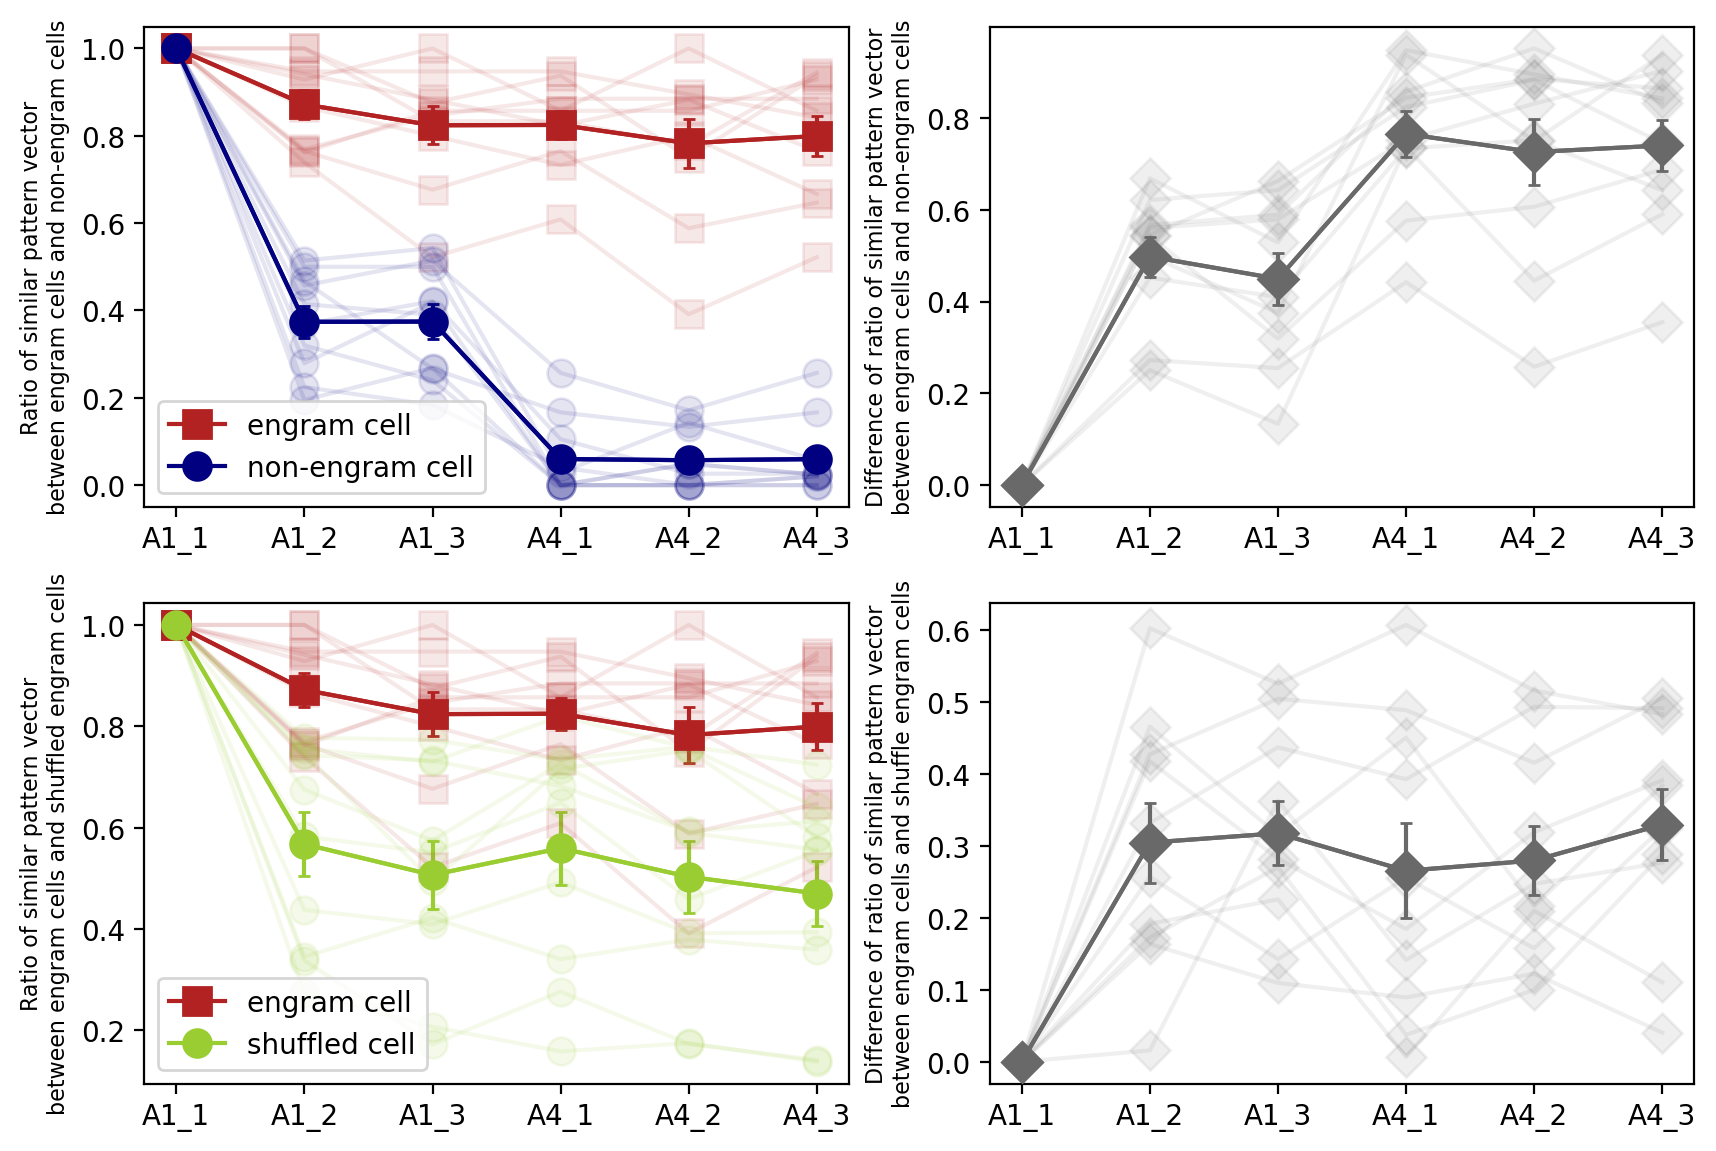

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7), dpi=200)

x = engram_matching_score.columns

# mean of MS between engram and non-engram
engram_y, engram_err = engram_matching_score.mean(), engram_matching_score.sem()
non_engram_y, non_engram_err = non_engram_matching_score.mean(), non_engram_matching_score.sem()

axes[0][0].errorbar(x, engram_y, yerr=engram_err, capsize=2, c='firebrick')
axes[0][0].plot(x, engram_y, marker='s', markersize=10, label='engram cell', c='firebrick', zorder=12)
axes[0][0].errorbar(x, non_engram_y, yerr=non_engram_err, capsize=2, c='navy')
axes[0][0].plot(x, non_engram_y, marker='o', markersize=10, label='non-engram cell', c='navy', zorder=12)

for index, rows in engram_matching_score.iterrows():
    axes[0][0].plot(x, rows, marker='s', markersize=10, c='firebrick', alpha=0.1)
    
for index, rows in non_engram_matching_score.iterrows():
    axes[0][0].plot(x, rows, marker='o', markersize=10, c='navy', alpha=0.1)

axes[0][0].set_ylabel('Ratio of similar pattern vector\nbetween engram cells and non-engram cells', fontsize=8)
axes[0][0].legend()

# diff in MS between engram and non-engram
diffs = engram_matching_score - non_engram_matching_score
diff_mean, diff_err = diffs.mean(), diffs.sem()

axes[0][1].errorbar(x, diff_mean, yerr=diff_err, capsize=2, c='dimgray')
axes[0][1].plot(x, diff_mean, marker='D', markersize=10, c='dimgray', zorder=12)

for index, rows in diffs.iterrows():
    axes[0][1].plot(x, rows, marker='D', markersize=10, c='dimgray', alpha=0.1)
    
axes[0][1].set_ylabel('Difference of ratio of similar pattern vector\nbetween engram cells and non-engram cells', fontsize=8)

# mean of MS between engram and shuffled engram
engram_y, engram_err = engram_matching_score.mean(), engram_matching_score.sem()
shuffle_y, shuffle_err = shuffle_engram_matching_score.mean(), shuffle_engram_matching_score.sem()

axes[1][0].errorbar(x, engram_y, yerr=engram_err, capsize=2, c='firebrick')
axes[1][0].plot(x, engram_y, marker='s', markersize=10, label='engram cell', c='firebrick', zorder=12)
axes[1][0].errorbar(x, shuffle_y, yerr=shuffle_err, capsize=2, c='yellowgreen')
axes[1][0].plot(x, shuffle_y, marker='o', markersize=10, label='shuffled cell', c='yellowgreen', zorder=12)

for index, rows in engram_matching_score.iterrows():
    axes[1][0].plot(x, rows, marker='s', markersize=10, c='firebrick', alpha=0.1)
    
for index, rows in shuffle_engram_matching_score.iterrows():
    axes[1][0].plot(x, rows, marker='o', markersize=10, c='yellowgreen', alpha=0.1)
    
axes[1][0].set_ylabel('Ratio of similar pattern vector\nbetween engram cells and shuffled engram cells', fontsize=8)
axes[1][0].legend()

# diff in MS between engram and shuffle engram
diffs = engram_matching_score - shuffle_engram_matching_score
diff_mean, diff_err = diffs.mean(), diffs.sem()

axes[1][1].errorbar(x, diff_mean, yerr=diff_err, capsize=2, c='dimgray')
axes[1][1].plot(x, diff_mean, marker='D', markersize=10, c='dimgray', zorder=12)

for index, rows in diffs.iterrows():
    axes[1][1].plot(x, rows, marker='D', markersize=10, c='dimgray', alpha=0.1)
    
axes[1][1].set_ylabel('Difference of ratio of similar pattern vector\nbetween engram cells and shuffle engram cells', fontsize=8)

fig.show()

In [93]:
index = const.ANIMAL_NAMES
columns = ['post', 'pre']
pre_post_engram_matching_score = pd.DataFrame(index=index, columns=columns)
pre_post_non_engram_matching_score = pd.DataFrame(index=index, columns=columns)

for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    pre_engram, pre_non_engram = split_engram_matrix(animal_name, 'A1preES')
    post_engram, post_non_engram = split_engram_matrix(animal_name, 'A1postES')

    pre_nan_engram_cells = all_nan_cells(pre_engram)
    pre_nan_non_engram_cells = all_nan_cells(pre_non_engram)
    post_nan_engram_cells = all_nan_cells(post_engram)
    post_nan_non_engram_cells = all_nan_cells(post_non_engram)
    
    droped_engram_cells = droped_unique_cells(pre_nan_engram_cells, post_nan_engram_cells)
    droped_non_engram_cells = droped_unique_cells(pre_nan_non_engram_cells, post_nan_non_engram_cells)
    
    pre_engram.drop(columns=droped_engram_cells, inplace=True)
    pre_non_engram.drop(columns=droped_non_engram_cells, inplace=True)

    post_engram.drop(columns=droped_engram_cells, inplace=True)
    post_non_engram.drop(columns=droped_non_engram_cells, inplace=True)
    
    _, _, pre_engram  = split_matrix(pre_engram, 'A1preES')
    post_engram, _, _ = split_matrix(post_engram, 'A1postES')

    _, _, pre_non_engram  = split_matrix(pre_non_engram, 'A1preES')
    post_non_engram, _, _ = split_matrix(post_non_engram, 'A1postES')
    
    engram_df = {}
    engram_df['pre'] = pre_engram
    engram_df['post'] = post_engram
    engram_patterns = build_pattern_vectors(engram_df)

    pre_post_engram_matching_score.loc[animal_name, 'post'] = calc_matching_score(engram_patterns['post'], engram_patterns['post'])
    pre_post_engram_matching_score.loc[animal_name, 'pre'] = calc_matching_score(engram_patterns['post'], engram_patterns['pre'])

    non_engram_df = {}
    non_engram_df['pre'] = pre_non_engram
    non_engram_df['post'] = post_non_engram
    non_engram_patterns = build_pattern_vectors(non_engram_df)

    pre_post_non_engram_matching_score.loc[animal_name, 'post'] = calc_matching_score(non_engram_patterns['post'], non_engram_patterns['post'])
    pre_post_non_engram_matching_score.loc[animal_name, 'pre'] = calc_matching_score(non_engram_patterns['post'], non_engram_patterns['pre'])


animal_name: ID181106CreA
animal_name: ID181106CreB
animal_name: ID181106CreC
animal_name: ID181106CreG
animal_name: ID181106CreH
animal_name: ID181106CreI
animal_name: ID181106CreK
animal_name: ID181106CreL
animal_name: ID181106CreN
animal_name: ID181106CreQ


In [94]:
#pre_post_engram_matching_score.sort_index(axis='columns', inplace=True)
#pre_post_non_engram_matching_score.sort_index(axis='columns', inplace=True)

In [95]:
pre_post_engram_matching_score

,post,pre
ID181106CreA,1.0,0.55
ID181106CreB,1.0,0.809524
ID181106CreC,1.0,0.772727
ID181106CreG,1.0,0.741935
ID181106CreH,1.0,0.185185
ID181106CreI,1.0,0.37037
ID181106CreK,1.0,0.5
ID181106CreL,1.0,0.809524
ID181106CreN,1.0,0.703704
ID181106CreQ,1.0,0.9


In [96]:
pre_post_non_engram_matching_score

,post,pre
ID181106CreA,1.0,0.065217
ID181106CreB,1.0,0.232558
ID181106CreC,1.0,0.538462
ID181106CreG,1.0,0.175
ID181106CreH,1.0,0.081633
ID181106CreI,1.0,0.368421
ID181106CreK,1.0,0.095238
ID181106CreL,1.0,0.166667
ID181106CreN,1.0,0.042553
ID181106CreQ,1.0,0.255814


In [97]:
pre_post_engram_matching_score.mean()

post    1.000000
pre     0.634297
dtype: float64

In [98]:
pre_post_non_engram_matching_score.mean()

post    1.000000
pre     0.202156
dtype: float64

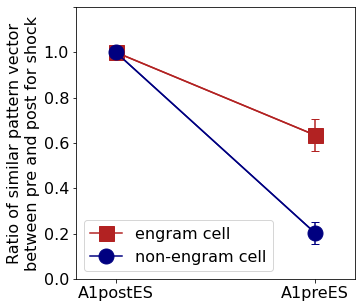

In [102]:
#left = np.arange(-0.1, 1.1, 1.0)
#width = 0.20
#
#index = const.ANIMAL_NAMES
#columns = ['engram cells', 'non-engram cells']
#post_matching_score_df = pd.DataFrame(index=index, columns=columns)
#pre_matching_score_df = pd.DataFrame(index=index, columns=columns)
#
#post_matching_score_df.loc[:, 'engram cells'] = pre_post_engram_matching_score.loc[:, 'post']
#post_matching_score_df.loc[:, 'non-engram cells'] = pre_post_non_engram_matching_score.loc[:, 'post']
#
#pre_matching_score_df.loc[:, 'engram cells'] = pre_post_engram_matching_score.loc[:, 'pre']
#pre_matching_score_df.loc[:, 'non-engram cells'] = pre_post_non_engram_matching_score.loc[:, 'pre']
#
#fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
#
#post_mean, post_sem = post_matching_score_df.mean(), post_matching_score_df.sem()
#pre_mean, pre_sem = pre_matching_score_df.mean(), pre_matching_score_df.sem()
#
#ax.bar(x=left, height=post_mean, yerr=post_sem, capsize=2, width=width, label='A1postES', align='center', color='royalblue')
#ax.bar(x=left + width, height=pre_mean, yerr=pre_sem, capsize=2, width=width, label='A1preES', align='center', color='tomato')
#ax.set_xticks([0.0, 1.0])
#ax.set_xticklabels(labels=['Engram cells', 'Non-Engram cells'])
#ax.legend(loc='upper center')
#
#fig.show()

fig, ax = plt.subplots(figsize=(5, 5))

x = ['A1postES', 'A1preES']
engram_y, engram_err = pre_post_engram_matching_score.mean(), pre_post_engram_matching_score.sem()
non_engram_y, non_engram_err = pre_post_non_engram_matching_score.mean(), pre_post_non_engram_matching_score.sem()

ax.errorbar(x, engram_y, yerr=engram_err, capsize=4, c='firebrick')
ax.plot(x, engram_y, marker='s', markersize=15, label='engram cell', c='firebrick', zorder=12)
ax.errorbar(x, non_engram_y, yerr=non_engram_err, capsize=4, c='navy')
ax.plot(x, non_engram_y, marker='o', markersize=15, label='non-engram cell', c='navy', zorder=12)

ax.set_ylabel('Ratio of similar pattern vector\nbetween pre and post for shock', fontsize=16)
ax.set_xlim(-0.2, 1.2)
ax.set_xticks([0.0, 1.0])
ax.set_xticklabels(['A1postES', 'A1preES'], fontsize=16)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, ''], fontsize=16)
ax.legend(fontsize=16, loc='lower left')
fig.show()

In [4]:
# matching score for all session

index = const.ANIMAL_NAMES
columns = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']

all_engram_matching_score = pd.DataFrame(index=columns, columns=columns)
all_non_engram_matching_score = pd.DataFrame(index=columns, columns=columns)

a1_1_engram_matching_score = pd.DataFrame(index=index, columns=columns)
a1_1_non_engram_matching_score = pd.DataFrame(index=index, columns=columns)

a1_2_engram_matching_score = pd.DataFrame(index=index, columns=columns)
a1_2_non_engram_matching_score = pd.DataFrame(index=index, columns=columns)

a1_3_engram_matching_score = pd.DataFrame(index=index, columns=columns)
a1_3_non_engram_matching_score = pd.DataFrame(index=index, columns=columns)

a4_1_engram_matching_score = pd.DataFrame(index=index, columns=columns)
a4_1_non_engram_matching_score = pd.DataFrame(index=index, columns=columns)

a4_2_engram_matching_score = pd.DataFrame(index=index, columns=columns)
a4_2_non_engram_matching_score = pd.DataFrame(index=index, columns=columns)

a4_3_engram_matching_score = pd.DataFrame(index=index, columns=columns)
a4_3_non_engram_matching_score = pd.DataFrame(index=index, columns=columns)

for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    A1postES_engram, A1postES_non_engram = split_engram_matrix(animal_name, 'A1postES')
    A4postES_engram, A4postES_non_engram = split_engram_matrix(animal_name, 'A4postES')

    A1postES_nan_engram_cells = all_nan_cells(A1postES_engram)
    A1postES_nan_non_engram_cells = all_nan_cells(A1postES_non_engram)
    A4postES_nan_engram_cells = all_nan_cells(A4postES_engram)
    A4postES_nan_non_engram_cells = all_nan_cells(A4postES_non_engram)
    
    droped_engram_cells = droped_unique_cells(A1postES_nan_engram_cells, A4postES_nan_engram_cells)
    droped_non_engram_cells = droped_unique_cells(A1postES_nan_non_engram_cells, A4postES_nan_non_engram_cells)
    
    A1postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A1postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)

    A4postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A4postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)
    
    engram_A1postES_1, engram_A1postES_2, engram_A1postES_3 = split_matrix(A1postES_engram, 'A1postES')
    engram_A4postES_1, engram_A4postES_2, engram_A4postES_3 = split_matrix(A4postES_engram, 'A4postES')

    non_engram_A1postES_1, non_engram_A1postES_2, non_engram_A1postES_3 = split_matrix(A1postES_non_engram, 'A1postES')
    non_engram_A4postES_1, non_engram_A4postES_2, non_engram_A4postES_3 = split_matrix(A4postES_non_engram, 'A4postES')
    
    engram_df = {}
    engram_df['A1_1'] = engram_A1postES_1
    engram_df['A1_2'] = engram_A1postES_2
    engram_df['A1_3'] = engram_A1postES_3
    engram_df['A4_1'] = engram_A4postES_1
    engram_df['A4_2'] = engram_A4postES_2
    engram_df['A4_3'] = engram_A4postES_3
    engram_patterns = build_pattern_vectors(engram_df)

    a1_1_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A1_1'])
    a1_1_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A1_2'])
    a1_1_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A1_3'])
    a1_1_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A4_1'])
    a1_1_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A4_2'])
    a1_1_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A4_3'])

    a1_2_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(engram_patterns['A1_2'], engram_patterns['A1_1'])
    a1_2_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(engram_patterns['A1_2'], engram_patterns['A1_2'])
    a1_2_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(engram_patterns['A1_2'], engram_patterns['A1_3'])
    a1_2_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(engram_patterns['A1_2'], engram_patterns['A4_1'])
    a1_2_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(engram_patterns['A1_2'], engram_patterns['A4_2'])
    a1_2_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(engram_patterns['A1_2'], engram_patterns['A4_3'])

    a1_3_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(engram_patterns['A1_3'], engram_patterns['A1_1'])
    a1_3_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(engram_patterns['A1_3'], engram_patterns['A1_2'])
    a1_3_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(engram_patterns['A1_3'], engram_patterns['A1_3'])
    a1_3_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(engram_patterns['A1_3'], engram_patterns['A4_1'])
    a1_3_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(engram_patterns['A1_3'], engram_patterns['A4_2'])
    a1_3_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(engram_patterns['A1_3'], engram_patterns['A4_3'])

    a4_1_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(engram_patterns['A4_1'], engram_patterns['A1_1'])
    a4_1_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(engram_patterns['A4_1'], engram_patterns['A1_2'])
    a4_1_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(engram_patterns['A4_1'], engram_patterns['A1_3'])
    a4_1_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(engram_patterns['A4_1'], engram_patterns['A4_1'])
    a4_1_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(engram_patterns['A4_1'], engram_patterns['A4_2'])
    a4_1_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(engram_patterns['A4_1'], engram_patterns['A4_3'])

    a4_2_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(engram_patterns['A4_2'], engram_patterns['A1_1'])
    a4_2_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(engram_patterns['A4_2'], engram_patterns['A1_2'])
    a4_2_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(engram_patterns['A4_2'], engram_patterns['A1_3'])
    a4_2_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(engram_patterns['A4_2'], engram_patterns['A4_1'])
    a4_2_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(engram_patterns['A4_2'], engram_patterns['A4_2'])
    a4_2_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(engram_patterns['A4_2'], engram_patterns['A4_3'])

    a4_3_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(engram_patterns['A4_3'], engram_patterns['A1_1'])
    a4_3_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(engram_patterns['A4_3'], engram_patterns['A1_2'])
    a4_3_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(engram_patterns['A4_3'], engram_patterns['A1_3'])
    a4_3_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(engram_patterns['A4_3'], engram_patterns['A4_1'])
    a4_3_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(engram_patterns['A4_3'], engram_patterns['A4_2'])
    a4_3_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(engram_patterns['A4_3'], engram_patterns['A4_3'])

    
    non_engram_df = {}
    non_engram_df['A1_1'] = non_engram_A1postES_1
    non_engram_df['A1_2'] = non_engram_A1postES_2
    non_engram_df['A1_3'] = non_engram_A1postES_3
    non_engram_df['A4_1'] = non_engram_A4postES_1
    non_engram_df['A4_2'] = non_engram_A4postES_2
    non_engram_df['A4_3'] = non_engram_A4postES_3
    non_engram_patterns = build_pattern_vectors(non_engram_df)
    
    a1_1_non_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A1_1'])
    a1_1_non_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A1_2'])
    a1_1_non_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A1_3'])
    a1_1_non_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A4_1'])
    a1_1_non_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A4_2'])
    a1_1_non_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A4_3'])
    
    a1_2_non_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(non_engram_patterns['A1_2'], non_engram_patterns['A1_1'])
    a1_2_non_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(non_engram_patterns['A1_2'], non_engram_patterns['A1_2'])
    a1_2_non_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(non_engram_patterns['A1_2'], non_engram_patterns['A1_3'])
    a1_2_non_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(non_engram_patterns['A1_2'], non_engram_patterns['A4_1'])
    a1_2_non_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(non_engram_patterns['A1_2'], non_engram_patterns['A4_2'])
    a1_2_non_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(non_engram_patterns['A1_2'], non_engram_patterns['A4_3'])
    
    a1_3_non_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(non_engram_patterns['A1_3'], non_engram_patterns['A1_1'])
    a1_3_non_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(non_engram_patterns['A1_3'], non_engram_patterns['A1_2'])
    a1_3_non_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(non_engram_patterns['A1_3'], non_engram_patterns['A1_3'])
    a1_3_non_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(non_engram_patterns['A1_3'], non_engram_patterns['A4_1'])
    a1_3_non_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(non_engram_patterns['A1_3'], non_engram_patterns['A4_2'])
    a1_3_non_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(non_engram_patterns['A1_3'], non_engram_patterns['A4_3'])
    
    a4_1_non_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(non_engram_patterns['A4_1'], non_engram_patterns['A1_1'])
    a4_1_non_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(non_engram_patterns['A4_1'], non_engram_patterns['A1_2'])
    a4_1_non_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(non_engram_patterns['A4_1'], non_engram_patterns['A1_3'])
    a4_1_non_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(non_engram_patterns['A4_1'], non_engram_patterns['A4_1'])
    a4_1_non_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(non_engram_patterns['A4_1'], non_engram_patterns['A4_2'])
    a4_1_non_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(non_engram_patterns['A4_1'], non_engram_patterns['A4_3'])
    
    a4_2_non_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(non_engram_patterns['A4_2'], non_engram_patterns['A1_1'])
    a4_2_non_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(non_engram_patterns['A4_2'], non_engram_patterns['A1_2'])
    a4_2_non_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(non_engram_patterns['A4_2'], non_engram_patterns['A1_3'])
    a4_2_non_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(non_engram_patterns['A4_2'], non_engram_patterns['A4_1'])
    a4_2_non_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(non_engram_patterns['A4_2'], non_engram_patterns['A4_2'])
    a4_2_non_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(non_engram_patterns['A4_2'], non_engram_patterns['A4_3'])
    
    a4_3_non_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(non_engram_patterns['A4_3'], non_engram_patterns['A1_1'])
    a4_3_non_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(non_engram_patterns['A4_3'], non_engram_patterns['A1_2'])
    a4_3_non_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(non_engram_patterns['A4_3'], non_engram_patterns['A1_3'])
    a4_3_non_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(non_engram_patterns['A4_3'], non_engram_patterns['A4_1'])
    a4_3_non_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(non_engram_patterns['A4_3'], non_engram_patterns['A4_2'])
    a4_3_non_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(non_engram_patterns['A4_3'], non_engram_patterns['A4_3'])


animal_name: ID181106CreA
animal_name: ID181106CreB
animal_name: ID181106CreC
animal_name: ID181106CreG


/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


animal_name: ID181106CreH
animal_name: ID181106CreI
animal_name: ID181106CreK
animal_name: ID181106CreL
animal_name: ID181106CreN
animal_name: ID181106CreQ


In [5]:
all_engram_matching_score.loc['A1_1', :] = a1_1_engram_matching_score.mean()
all_engram_matching_score.loc['A1_2', :] = a1_2_engram_matching_score.mean()
all_engram_matching_score.loc['A1_3', :] = a1_3_engram_matching_score.mean()
all_engram_matching_score.loc['A4_1', :] = a4_1_engram_matching_score.mean()
all_engram_matching_score.loc['A4_2', :] = a4_2_engram_matching_score.mean()
all_engram_matching_score.loc['A4_3', :] = a4_3_engram_matching_score.mean()

all_non_engram_matching_score.loc['A1_1', :] = a1_1_non_engram_matching_score.mean()
all_non_engram_matching_score.loc['A1_2', :] = a1_2_non_engram_matching_score.mean()
all_non_engram_matching_score.loc['A1_3', :] = a1_3_non_engram_matching_score.mean()
all_non_engram_matching_score.loc['A4_1', :] = a4_1_non_engram_matching_score.mean()
all_non_engram_matching_score.loc['A4_2', :] = a4_2_non_engram_matching_score.mean()
all_non_engram_matching_score.loc['A4_3', :] = a4_3_non_engram_matching_score.mean()

In [6]:
all_engram_matching_score

,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
A1_1,1.0,0.871875,0.823956,0.824737,0.782617,0.799455
A1_2,0.890907,1.0,0.808071,0.813899,0.801368,0.798465
A1_3,0.867762,0.868387,1.0,0.777875,0.795145,0.763001
A4_1,0.812319,0.780981,0.735659,1.0,0.855666,0.851598
A4_2,0.786264,0.768636,0.725656,0.893323,1.0,0.864856
A4_3,0.790115,0.766111,0.717883,0.877142,0.831336,1.0


In [7]:
all_non_engram_matching_score

,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
A1_1,1.0,0.373983,0.374568,0.059846,0.05715,0.059646
A1_2,0.351617,1.0,0.494273,0.05727,0.035775,0.051576
A1_3,0.359504,0.463498,1.0,0.068858,0.090233,0.087614
A4_1,0.049925,0.04705,0.088599,1.0,0.422971,0.416084
A4_2,0.072111,0.040055,0.085272,0.441032,1.0,0.508369
A4_3,0.069888,0.044212,0.091171,0.45512,0.499562,1.0


In [8]:
import seaborn as sns

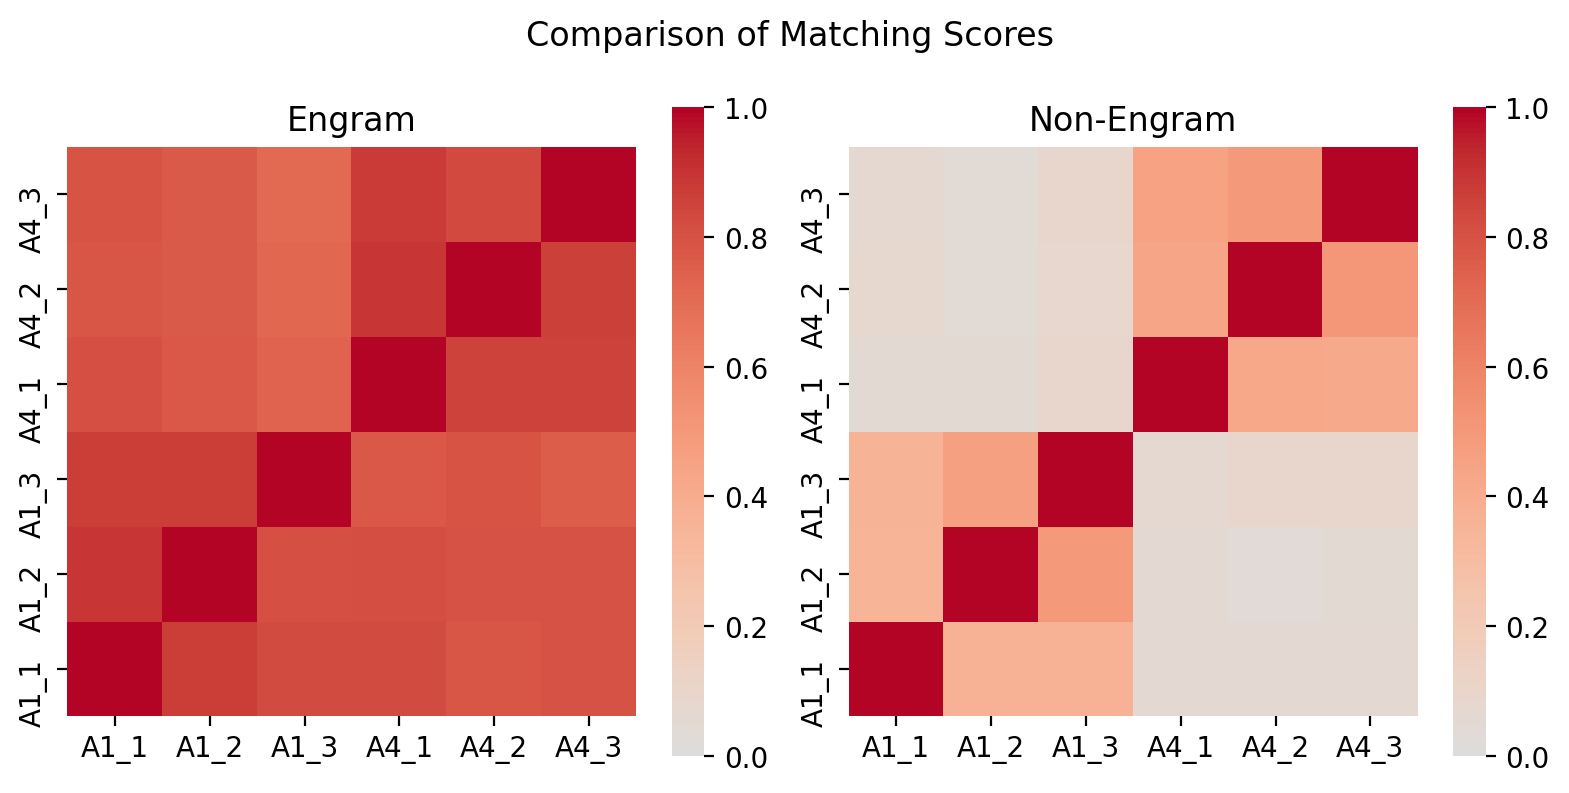

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), tight_layout=True, dpi=200)
color = 'coolwarm'

ax_for_engram = sns.heatmap(all_engram_matching_score.astype(float), ax=axes[0], vmin=0.0, vmax=1.0, center=0.0, square=True, cmap=color)
ax_for_engram.invert_yaxis()
ax_for_engram.set_title('Engram')

ax_for_non_engram = sns.heatmap(all_non_engram_matching_score.astype(float), ax=axes[1], vmin=0.0, vmax=1.0, center=0.0, square=True, cmap=color)
ax_for_non_engram.invert_yaxis()
ax_for_non_engram.set_title('Non-Engram')

fig.suptitle('Comparison of Matching Scores')
fig.show()